In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git, os, requests, json, pickle, time
import db_access
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import k_means
from scipy.optimize import curve_fit
from scipy.special import factorial
from importlib import reload

# Loading INSPIRE and Rumor mill data, creation of basic features

In [1334]:
years = [2017, 2018, 2019, 2020]
raw_data = {}
people = {}
for year in years:
    current_raw_data = pd.read_csv('rumors/data/rm'+str(year)+'.csv',sep=',',encoding='latin')
    raw_data[year] = current_raw_data
    people[year] = current_raw_data.sort_values(['Inspire link'])['Inspire link'].unique()

Dictionary to map special status (eg "Fancy fellowship, Offered/Accepted/Declined") into "Offered/Accepted/Declined, Special"

In [1337]:
status_dict = {}
for year in years:
    statuses = np.copy(raw_data[year]['Status'].unique())
    statuses_clean = []
    
    for status in statuses:
        if status == 'Offered': statuses_clean.append('Offered')
        elif status == 'Accepted': statuses_clean.append('Accepted')
        elif status == 'Declined': statuses_clean.append('Declined')
        elif status.find('Offered')>0: statuses_clean.append('Offered, Special')
        elif status.find('Accepted')>0: statuses_clean.append('Accepted, Special')
        elif status.find('Declined')>0: statuses_clean.append('Declined, Special') 
        else: statuses_clean.append('Unreadable')
            
    status_dict[year]=dict(zip(statuses,statuses_clean))
    

In [1343]:
number_of_offers = {}
data = {}
for year in years:
    number_of_offers[year] = [len(raw_data[year][raw_data[year]['Inspire link']==person]['Institution'].unique()) for person in people[year]]
    data[year] = pd.DataFrame(people[year],columns=['Person'])

In [62]:
inspire_data = {}
for year in years:
    t0 = time.perf_counter() 
    inspire_data[year] = []
    for person in people[year]:
        response = requests.get(f"http://old.inspirehep.net/search?p=ea:{person}+&rg=75&of=recjson&ot=recid,creation_date,number_of_authors,authors")
        inspire_data[year].append(json.loads(response.text))
    print(year, time.perf_counter()-t0)

2017 514.0181758645922
2018 338.96896791271865
2019 354.9714118987322
2020 202.30416318774223


In [65]:
paper_series = {}
for year in years:
    paper_series[year] = pd.Series(dict(zip(people[year],inspire_data[year])))

Save the Inspire data dictionary in a file. Data takes a long time to download, so avoid re-running.

In [66]:
for year in years:
    paper_series[year].to_pickle('data/paper_series_2_'+str(year))

# Loading previously downloaded data, start here

In [432]:
years = [2017, 2018, 2019, 2020]
raw_data = {}
people = {}
paper_series_series = {}
for year in years:
    current_raw_data = pd.read_csv('data/rm'+str(year)+'.csv',sep=',',encoding='latin')
    raw_data[year] = current_raw_data
    people[year] = current_raw_data.sort_values(['Inspire link'])['Inspire link'].unique()
    paper_series_series[year] = pd.read_pickle(f'data/paper_series_2_{year}')

This function creates all features from the downloaded InspireHEP data

In [417]:
def get_affiliations(person, author_lists):
    """Get list of unique affiliations for person from list of (author lists of papers)"""
    affiliations = []
    for author_list in author_lists:
        author_frame = pd.DataFrame(author_list)
        try:
            affiliation = author_frame[author_frame['full_name'].str.contains(person.split('.')[-2])]['affiliation'].values[0]
        except:
            continue
        
        
        if type(affiliation)==str:
            affiliations.append(affiliation.lower().replace('(main)','').strip())

        
        elif type(affiliation) == list:
            if len(affiliation)>0:
                for aff in affiliation: 
                    affiliations.append(aff.lower().replace('(main)','').strip())
        else:
            print('Warning! Affiliation problem with', person)
    return list(set(affiliations))

In [229]:
def get_citation_counts(recid_list, year):
    citation_counts = []
    for recid in recid_list:
        citation_counts.append(db_access.get_citations(recid, f'{year}-01-01'))
    return citation_counts

In [208]:
def make_author_lists(paper_series, year):
    return [paper['authors'] for paper in paper_series if pd.to_datetime(paper['creation_date']) < pd.to_datetime(f'{year}-01-01')]

In [346]:
def analyze(person, paper_series, year):
    """Create all relevant feature for a single individual. 
    Take as input INSPIRE ID, Pandas series containing papers of author and year of application.
    Return a dictionary with all features"""
    return_dict = {}
    
    paper_frame = pd.DataFrame(paper_series,columns=['recid','creation_date','number_of_authors'])#Put single-valued fields in a data frame
    paper_frame['creation_date'] = pd.to_datetime(paper_frame['creation_date'])
    paper_frame = paper_frame[paper_frame['creation_date'] < pd.to_datetime(f'{year}-01-01')]
    
    paper_dates = paper_frame['creation_date'].values
    #Can probably drop
    
    author_lists = make_author_lists(paper_series, year)
    
    # Affiliation features:
    return_dict['affiliations'] = get_affiliations(person, author_lists)
    return_dict['affiliations_total'] = len(return_dict['affiliations'])          
    return_dict['collaboration'] = paper_frame['number_of_authors'].max()>15

    #Features concerning number of papers
    #This data does not need to be date-adjusted, since INSPIRE calls were already limited to the correct date
    return_dict['papers_total'] = len(paper_frame)
    return_dict['papers_last_year'] = len(paper_frame[pd.to_datetime(paper_frame['creation_date']) > pd.to_datetime(f'01/01/{year-1}')])
    return_dict['papers_three_years'] = len(paper_frame[pd.to_datetime(paper_frame['creation_date']) > pd.to_datetime(f'01/01/{year-3}')])

    #Features concerning citations
    citation_counts = get_citation_counts(paper_frame['recid'], year)
    return_dict['citations_total'] = sum(citation_counts)
    if len(citation_counts)>0:
        return_dict['citations_median'] = np.median(citation_counts)
        return_dict['citations_max'] = np.max(citation_counts)
        return_dict['citations_per_paper'] = np.mean(citation_counts)
    else:        
        return_dict['citations_median'] = np.nan
        return_dict['citations_max'] = np.nan
        return_dict['citations_per_paper'] = np.nan
        
    #Number of offers
    return_dict['offers'] = len(raw_data[year][raw_data[year]['Inspire link']==person]['Institution'].unique())

    
    if len(paper_dates)>1:
        return_dict['time_since_paper2'] = (pd.to_datetime('01/01/'+str(year))-np.sort(paper_dates)[1]).days/365.
        return_dict['time_since_paper1'] = (pd.to_datetime('01/01/'+str(year))-np.sort(paper_dates)[0]).days/365.
    else:
        return_dict['time_since_paper2'] = 0.
        return_dict['time_since_paper1'] = 0.
    return return_dict

In [433]:
reload(db_access)   #Run to wake up SQL server

<module 'db_access' from '/data1/garnier/rumors/db_access.py'>

In [438]:
#analyzed_data = {}
for year in [2018,2019,2020]:
    t= time.perf_counter()
  
    year_list = []
    error_list = []
    for i,person in enumerate(people[year]):
        try:
            year_list.append(analyze(person, paper_series_series[year][person], year))
        except:
            print("There was an error with ",person,", they were not added to the data")
            error_list.append(person)
        
        if i == len(people[year])//2: print("Halfway through year ", year)
        
    analyzed_data[year] = pd.DataFrame(year_list, [person for person in people[year] if person not in error_list]) 
    print('Time to run year: ', time.perf_counter()-t)
   # if input(f'Number of entries with a NAN: {len(analyzed_data[year])-len(analyzed_data[year].dropna())}. Drop? y/n >')=='y':
    #    analyzed_data[year] = analyzed_data[year].dropna()

Warning! Affiliation problem with Chien.Yi.Chen.1
Warning! Affiliation problem with D.R.Mayerson.1
Halfway through year  2018
Warning! Affiliation problem with O.Macias.1
Warning! Affiliation problem with R.Ruiz.1
Warning! Affiliation problem with Zhen.Liu.1
Time to run year:  284.7549293767661
Warning! Affiliation problem with C.Verhaaren.1
Warning! Affiliation problem with Ciaran.Hughes.1
Warning! Affiliation problem with D.Redigolo.1
Warning! Affiliation problem with Da.Liu.1
Warning! Affiliation problem with Elina.Fuchs.1
Warning! Affiliation problem with J.Baglio.1
Warning! Affiliation problem with Jeong.Han.Kim.1
Warning! Affiliation problem with Jonas.Wittbrodt.1
Halfway through year  2019
Warning! Affiliation problem with M.J.Schlaffer.1
Warning! Affiliation problem with S.Brass.1
Time to run year:  316.2691257279366
Warning! Affiliation problem with A.Joglekar.1
Warning! Affiliation problem with G.Durieux.1
Warning! Affiliation problem with G.R.Penington.1
Halfway through year

In [ ]:
for year in years:
    analyzed_data[year].to_pickle('data/analyzed_data_'+str(year))

# Visualization of available data

In [458]:
analyzed_data[2020].columns

Index(['affiliations', 'affiliations_total', 'collaboration', 'papers_total',
       'papers_last_year', 'papers_three_years', 'citations_total',
       'citations_median', 'citations_max', 'citations_per_paper', 'offers',
       'time_since_paper2', 'time_since_paper1'],
      dtype='object')

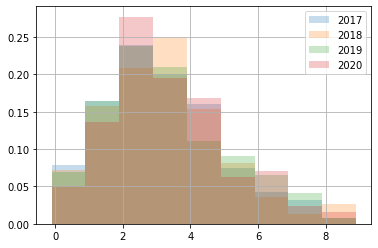

In [478]:
for year in years:
    analyzed_data[year]['papers_last_year'].hist(density=True, label=year, alpha=0.25, bins=-0.1+np.arange(10))
plt.legend()

## Role of collaboration ?

In [1506]:
analyzed_data[2020]['collaboration'].sum()/len(analyzed_data[2020])

0.21235521235521235

In [1508]:
def comparison_hist(feature, year):
    analyzed_data[year][analyzed_data[year]['collaboration']==True][feature].hist(density=True, color='blue', alpha=0.5, label='Collab.')
    analyzed_data[year][analyzed_data[year]['collaboration']==False][feature].hist(alpha=0.5, density=True, color='red', label='No collab')
    plt.axvline(analyzed_data[year][analyzed_data[year]['collaboration']==True][feature].median(), color='blue',lw=2)
    plt.axvline(analyzed_data[year][analyzed_data[year]['collaboration']==False][feature].median(), color='red',lw=2)
    plt.legend()

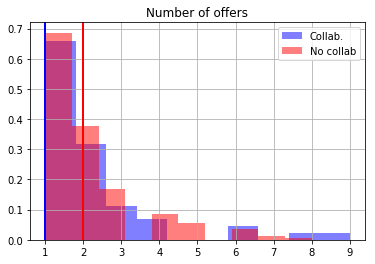

In [1510]:
comparison_hist('offers', 2020)
plt.title('Number of offers');